<a href="https://colab.research.google.com/github/hydro-7/Cat_v_Dog_Classification/blob/main/Dog_v_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hydro7","key":"b77069e6f4d8eaf633db009b9fe4da71"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Aug  9 17:15 kaggle.json


In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle #Create the directory

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!pwd #Print Working Directory

/content


In [10]:
!kaggle datasets list

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
waqi786/heart-attack-dataset                               ❤️ Heart Attack Risk Factors Dataset                 9KB  2024-08-06 10:57:42           1196         25  1.0              
youssefismail20/olympic-games-1994-2024                    Olympic Games (1994-2024) 🏅🌍                        16KB  2024-08-08 12:56:36           1088         26  1.0              
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           2823         40  1.0              
muhammadehsan000/credit-card-transaction-records-dataset   Credit Card Transaction Records

In [11]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:44<00:00, 19.2MB/s]
100% 812M/812M [00:44<00:00, 19.1MB/s]


In [12]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [13]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [14]:
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [17]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets, models

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import shutil

import requests
import zipfile
from pathlib import Path
from torch.utils.data import random_split

In [18]:
seed = 42

In [19]:
# Setup path to data folder
# data_path = Path("data/")
# image_path = data_path / "train"
image_path = Path("train")

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print("Khel khatam")

train directory exists.


Random image path: train/dog.1177.jpg
Image class: dog
Image height: 155
Image width: 195


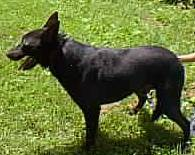

In [20]:
import random
from PIL import Image

# Set seed
random.seed(seed) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
# image_path_list = list(image_path.glob("*/*/*.jpg")) #error
# image_path_list = list(image_path.glob("*/*.jpg")) #error
image_path_list = list(image_path.glob("*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
#image_class = random_image_path.parent.stem #parent stem is train dir, so image class = train
image_class = random_image_path.name.split(".")[0]

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [21]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

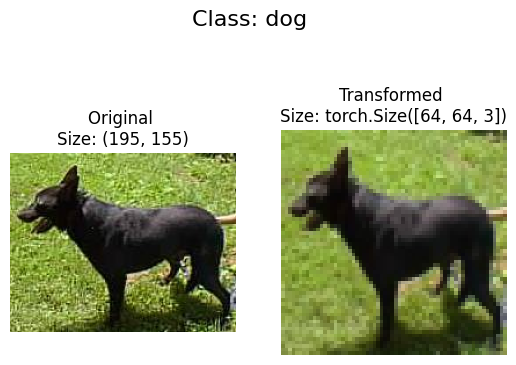

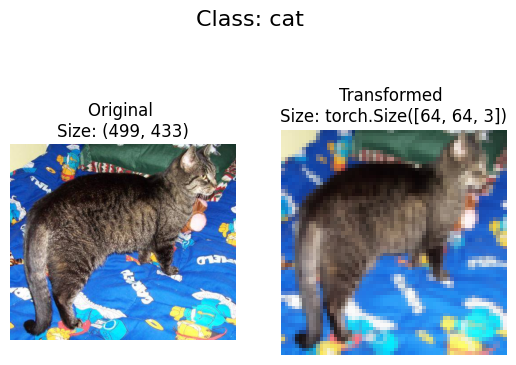

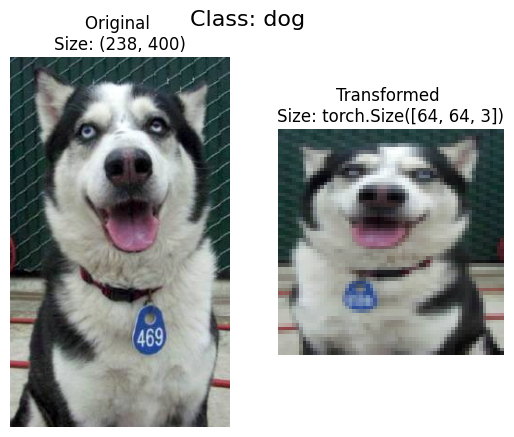

In [22]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

    # Plots a series of random images from image_paths.

    # Will open n image paths from image_paths, transform them
    # with transform and plot them side by side.

    # Args:
    #     image_paths (list): List of target image paths.
    #     transform (PyTorch Transforms): Transforms to apply to images.
    #     n (int, optional): Number of images to plot. Defaults to 3.
    #     seed (int, optional): Random seed for the random generator. Defaults to 42.

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            # fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            # fig.suptitle(f"Class: {random_image_path.name.split(".")[0]}", fontsize=16)
            str1 = image_path.name.split(".")[0]
            fig.suptitle(f"Class: {str1}", fontsize=16)


plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)
# image_path_list -> all images

In [23]:
train_folder = 'train'
cf = 'cats'
df = 'dogs'

In [24]:
cats_folder = os.path.join(train_folder, cf)

os.makedirs(cats_folder, exist_ok=True)

In [25]:
dogs_folder = os.path.join(train_folder, df)

os.makedirs(dogs_folder, exist_ok=True)

In [26]:
for source_path in image_path_list:
    image_class = source_path.name.split(".")[0]
    if image_class == "cat":
        # destination_path = os.path.join(nf1, source_path.name)
        destination_path = cats_folder
    else:
        # destination_path = os.path.join(nf2, source_path.name)
        destination_path = dogs_folder
    shutil.move(source_path, destination_path)

In [27]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=data_transform)
print(dataset.class_to_idx)
idx_to_class = {v:k for k,v in dataset.class_to_idx.items()}

{'cats': 0, 'dogs': 1}


In [28]:
data_size = len(dataset)
# Random split dataset
train_dataset, validation_dataset = random_split(dataset, [int(0.8 * data_size), int(0.2 * data_size)])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

torch.Size([1, 3, 256, 256])
This is a cats


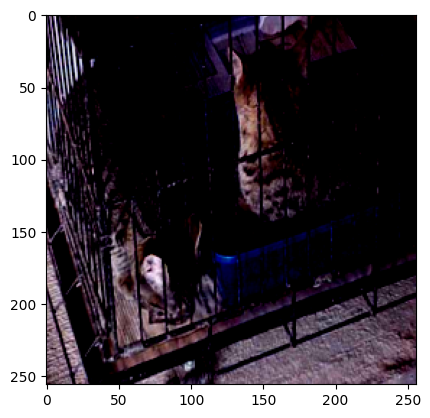

In [29]:
for value in train_dataloader:
    data, label = value
    print(data.shape)
    print(f"This is a {idx_to_class[int(label.item())]}")
    plt.imshow(torch.squeeze(data).permute(1, 2, 0))
    break

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [31]:
# Accuraccy 50% model == Equal to random choice
class VanilaMyNet(nn.Module):
    def __init__(self):
        super(VanilaMyNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(24)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(187500, 2)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv2(self.conv1(input))))
        output = self.pool(output)
        output = F.relu(self.bn2(self.conv3(output)))
        output = output.view(-1, 187500)
        output = self.fc1(output)

        return output

In [32]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [33]:
model = VanilaMyNet().to(device)
print(model)

VanilaMyNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=187500, out_features=2, bias=True)
)


In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [35]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(validation_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------------------
loss: 1.479768 [    0/20000]
loss: 3.853489 [  500/20000]
loss: 1.149306 [ 1000/20000]
loss: 0.927128 [ 1500/20000]
loss: 0.282411 [ 2000/20000]
loss: 1.843413 [ 2500/20000]
loss: 0.078020 [ 3000/20000]
loss: 0.858885 [ 3500/20000]
loss: 0.021422 [ 4000/20000]
loss: 0.560073 [ 4500/20000]
loss: 0.357974 [ 5000/20000]
loss: 1.243883 [ 5500/20000]
loss: 0.081865 [ 6000/20000]
loss: 1.152831 [ 6500/20000]
loss: 0.617427 [ 7000/20000]
loss: 0.767968 [ 7500/20000]
loss: 0.269123 [ 8000/20000]
loss: 2.463053 [ 8500/20000]
loss: 1.349774 [ 9000/20000]
loss: 0.115630 [ 9500/20000]
loss: 1.932303 [10000/20000]
loss: 0.054952 [10500/20000]
loss: 2.764616 [11000/20000]
loss: 2.871066 [11500/20000]
loss: 0.413418 [12000/20000]
loss: 0.985527 [12500/20000]
loss: 0.395819 [13000/20000]
loss: 0.248057 [13500/20000]
loss: 0.020200 [14000/20000]
loss: 0.056254 [14500/20000]
loss: 0.475104 [15000/20000]
loss: 2.220186 [15500/20000]
loss: 1.296211 [16000/20000]
loss: 0.64762